# Sealevel rise in the Netherlands

In the Netherlands, changes in the mean sealevel are tracked in the [zeespiegelmonitor](https://www.deltares.nl/expertise/onze-expertises/zeespiegelstijging/zeespiegelmonitor). The underlying observed annual mean sealevel values are taken from the [PSMSL database](https://psmsl.org/data/obtaining). The PSMSL collects monthly mean and annual mean sealevel data worldwide. Changes in the local reference, for example causes by subsidence or levelling updates, are compensated by translating values to a Revised Local Reference (RLR). This RLR has an offset with the current national NAP, that differs a bit per station. Rijkswaterstaat sends it's tide-gauge data to PSMSL every year after a thorough check of the data an possibly a correction based on recalibration of their instruments.

## Goals of this notebook

### An early estimate  of the annual mean

The process described above is thorough, but it's also slow. Updates in the zeespiegelmonitor tend to be published about a year after the end of the year. Here, we aim to make a rough estimate based on the raw measuerements, that become available a few minutes after the measurement is produced at the tide-gauge. This makes it possible to get a rough idea about the next value, even a bit before the end of the ongoing year.
Of course, these values are only rough estimates and both quality control and re-calibration can alter the values, it may be interesting to have a rough non official estimate much earlier. To assess the the impact of the quality control and re-calibration, a few overlapping years are collected.

### Sealevel rise and global temperature

At longer times-cales, sealevel rise is claimed ([Dangendorf etal 2014](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014JC009901)) to be related to the changes in the surrounding ocean. Here, a simplistic link between the global mean temperature from [Copernicus Climate](https://climate.copernicus.eu/copernicus-2024-virtually-certain-be-warmest-year-and-first-year-above-15degc) These values were computed by averaging temperatures from the ERA5 reanalysis.
It should be emphasized that such a regression is simplistic in many ways. For example, it does not account well for ice melt, since that has a delayed response to the temperature. Nor does it account for a potential non-linear response of the earth's systems.


In [17]:
# packages used
using HTTP
using CSV
using DataFrames
using Dates
using Plots

In [146]:
#	
labels = Dict("vlissingen"=>"Vlissingen","hoekvanholland"=>"Hoek van Holland","ijmuiden"=>"IJmuiden","harlingen"=>"Harlingen","denhelder"=>"Den Helder","delfzijl"=>"Delfzijl") 
psmsl_station_code= Dict( "vlissingen"=>20, 
"hoekvanholland"=>22,
"denhelder"=>23,
"delfzijl"=>24,
"harlingen"=>25,
"ijmuiden"=>32,)
@show psmsl_station_code["hoekvanholland"]

function psmsl_monthly_data(station_code)
    # https://psmsl.org/data/obtaining/rlr.monthly.data/20.rlrdata
    url = "https://www.psmsl.org/data/obtaining/rlr.monthly.data/$(station_code).rlrdata"
    println(url)
    df = CSV.File(HTTP.get(url).body, delim=';', header=false) |> DataFrame
    # Assign meaningful column names
    rename!(df, [:Year, :SeaLevel, :Col3, :Col4])
    return df
end

function psmsl_yearly_data(station_code)
    # https://psmsl.org/data/obtaining/rlr.annual.data/20.rlrdata
    url = "https://www.psmsl.org/data/obtaining/rlr.annual.data/$(station_code).rlrdata"
    println(url)
    df = CSV.File(HTTP.get(url).body, delim=';', header=false) |> DataFrame
    # Assign meaningful column names
    rename!(df, [:Year, :SeaLevel, :Col3, :Col4])
    return df
end


#hoekvanholland_monthly = psmsl_monthly_data(psmsl_station_code["hoekvanholland"])
#hoekvanholland_yearly = psmsl_yearly_data(psmsl_station_code["hoekvanholland"])
psmsl_yearly=Dict{String,DataFrame}()
for (key, value) in psmsl_station_code
    psmsl_yearly[key] = psmsl_yearly_data(value)
end
#@show psmsl_yearly["denhelder"]
nothing

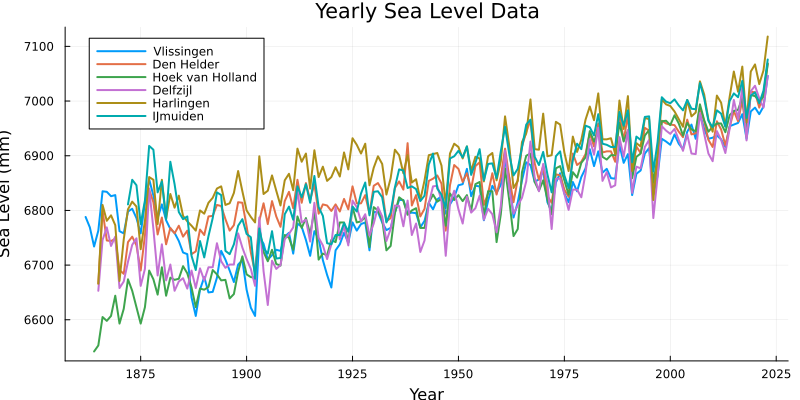

In [145]:
# Plot the yearly data
vlissingen_yearly = psmsl_yearly["vlissingen"]
using Plots
plot(vlissingen_yearly.Year, vlissingen_yearly.SeaLevel, label=labels["vlissingen"], xlabel="Year", ylabel="Sea Level (mm)", lw=2,
title="Yearly Sea Level Data", legend=:topleft,size=(800,400))
for (key, value) in psmsl_yearly
    if key!="vlissingen"
        plot!(value.Year, value.SeaLevel, label=labels[key],lw=2)
    end
end
plot!()

In [64]:
function download_matroos(location::String,source::String,unit::String,
    tstart::String,tstop::String)
    # the noos server is available to the public, but has a limited dataset
    url="https://noos.matroos.rws.nl/direct/get_series.php?loc=$(location)&source=$(source)&unit=$(unit)&tstart=$(tstart)&tstop=$(tstop)"
    response = HTTP.get(url)
    # Read the CSV data into a DataFrame
    df = CSV.File(HTTP.get(url).body, delim=' ', ignorerepeated=true, skipto=12, header=false) |> DataFrame
    rename!(df,["timestring","Sealevel"])
    df.Time = DateTime.(string.(df.timestring), "yyyymmddHHMM")
    return df
end

download_matroos (generic function with 1 method)

In [ ]:
# define mean
function mean(values)
    return sum(values)/length(values)
end

In [88]:
# Download matroos data
matroos_years = [2020,2021,2022,2023,2024]
matroos_locations = keys(labels)
matroos_source = "observed"
matroos_unit = "waterlevel"
#matroos_tide_unit = "waterlevel_astro"
start_of_year(year)="$(year)01010000"
end_of_year(year)="$(year)12312350"
matroos_10minute_data = Dict{String,DataFrame}()
for year in matroos_years
    for location in matroos_locations
        println("Downloading data for $(location) in $(year)")
        matroos_10minute_data["$(location)_$(year)"] = download_matroos(location,matroos_source,matroos_unit,start_of_year(year),end_of_year(year))
    end
end
# matroos_10minute_tide_data = Dict{String,DataFrame}()
# for year in matroos_years
#     for location in matroos_locations
#         println("Downloading tide data for $(location) in $(year)")
#         matroos_10minute_tide_data["$(location)_$(year)"] = download_matroos(location,matroos_source,matroos_tide_unit,start_of_year(year),end_of_year(year))
#     end
# end



In [90]:
#Compute yearly averages from 10minute data
matroos_yearly = Dict{String,DataFrame}()
const m_to_mm=1000.0
for location in matroos_locations
    values=zeros(length(matroos_years))
    for (i,year) in enumerate(matroos_years)
        mean_value=mean(matroos_10minute_data["$(location)_$(year)"].Sealevel)
        values[i]=m_to_mm*mean_value
    end
    matroos_yearly[location]=DataFrame(Year=matroos_years,SeaLevel=values)
end

@show matroos_yearly["denhelder"]

Row,Year,SeaLevel
,Int64,Float64
1,2020,68.944
2,2021,41.7973
3,2022,66.6578
4,2023,122.645
5,2024,136.251


In [104]:

station_offsets=Dict{String,Float64}()
for location in matroos_locations
    station_offsets[location]=mean(psmsl_yearly[location][end-2:end,2].-matroos_yearly[location][2:4,2])
end
#station_offsets=psmsl_yearly["denhelder"][end-2:end,2].-matroos_yearly["denhelder"][2:4,2]
#mean_station_offset=mean(station_offsets)
@show station_offsets


Dict{String, Float64} with 6 entries:
  "denhelder"      => 6946.3
  "vlissingen"     => 6930.0
  "hoekvanholland" => 6873.35
  "harlingen"      => 6914.49
  "delfzijl"       => 6823.69
  "ijmuiden"       => 6950.07

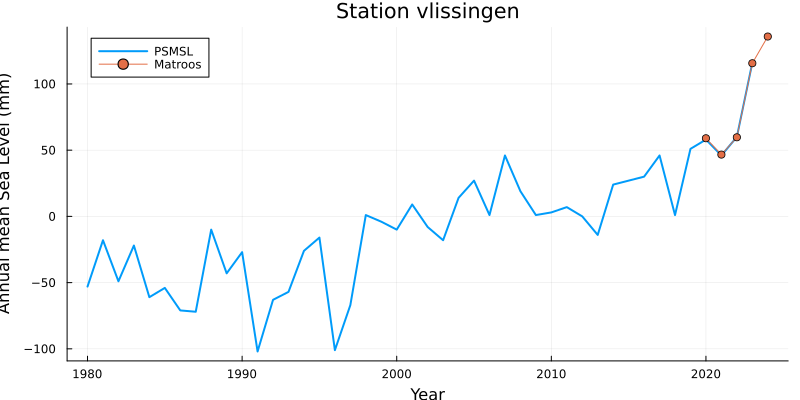

In [144]:
# Plot the yearly data
station="vlissingen"
for station in keys(psmsl_yearly)
    full_series = psmsl_yearly[station]
    selection=filter(row -> row.Year>=2000, full_series)
    # correct for offset
    selection.SeaLevel .-= station_offsets[station]
    plot(selection.Year, selection.SeaLevel, xlabel="Year", ylabel="Annual mean Sea Level (mm)",
    label="PSMSL", title="Station $(station)", lw=2, legend=:topleft,size=(800,400))   
    plot!(matroos_yearly[station].Year, matroos_yearly[station].SeaLevel, label="Matroos", marker=:circle)
    savefig("figures/series_$(station).png")
end
full_series = psmsl_yearly[station]
selection=filter(row -> row.Year>=1980, full_series)
# correct for offset
selection.SeaLevel .-= station_offsets[station]
plot(selection.Year, selection.SeaLevel, xlabel="Year", ylabel="Annual mean Sea Level (mm)",
label="PSMSL", lw=2,title="Station $(station)", legend=:topleft,size=(800,400))   
plot!(matroos_yearly[station].Year, matroos_yearly[station].SeaLevel, label="Matroos", marker=:circle)
#savefig("figures/series_including_2024_estimate_$(station).png")

## Compute the trend to the global mean temperature

The global mean temperature has been collected from Copernicus Climate [article](https://climate.copernicus.eu/copernicus-2024-virtually-certain-be-warmest-year-and-first-year-above-15degc) It was computed by averaging temperatures from the ERA5 reanalysis.

Projections of sealevelrise link a major part to the heating of the upper ocean, the steric effect, at longer time-scales. Here, I naively combine scaled plots to see if this link can be observed directly in the Netherlands.

In [123]:
# download the global mean temperature timeseries
temperature_url="https://climate.copernicus.eu/sites/default/files/custom-uploads/2411-October-CB/PR/C3S_PR_202410_Fig1_timeseries_annual_global_temperature_anomalies_ref1850-1900_data.csv"
temperature_df = CSV.File(HTTP.get(temperature_url).body, delim=',', header=true,skipto=9) |> DataFrame
rename!(temperature_df, [:Year, :Temperature])
@show temperature_df
nothing

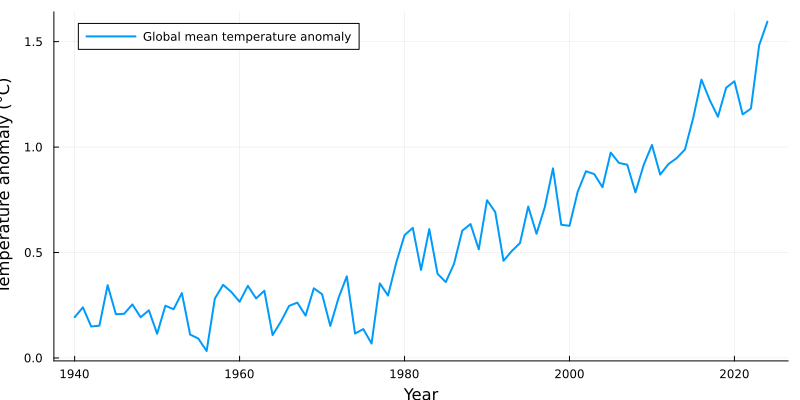

In [143]:
plot(temperature_df.Year, temperature_df.Temperature, xlabel="Year", ylabel="Temperature anomaly (°C)",label="Global mean temperature anomaly",lw=2,size=(800,400))

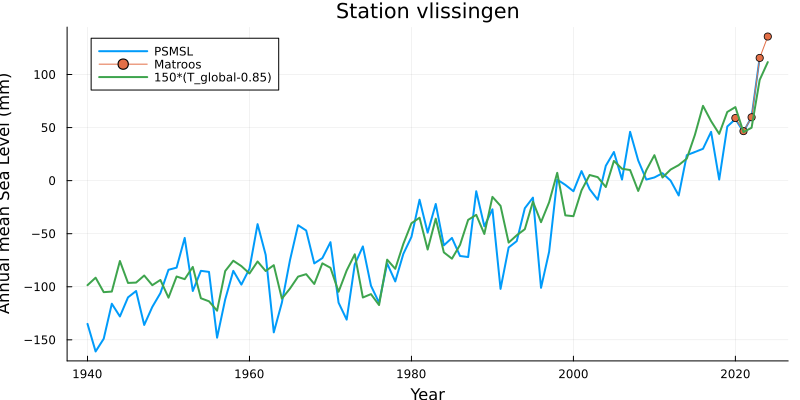

In [153]:
full_series = psmsl_yearly[station]
selection=filter(row -> row.Year>=1940, full_series)
# correct for offset
selection.SeaLevel .-= station_offsets[station]
plot(selection.Year, selection.SeaLevel, xlabel="Year", ylabel="Annual mean Sea Level (mm)",
label="PSMSL", title="Station $(station)", lw=2,legend=:topleft,size=(800,400))   
plot!(matroos_yearly[station].Year, matroos_yearly[station].SeaLevel, label="Matroos", marker=:circle)
plot!(temperature_df.Year, 150.0*(temperature_df.Temperature.-0.85), label="150*(T_global-0.85)", lw=2)
#savefig("figures/series_$(station)_including_regression_global_temperature.png")